In [1]:
%matplotlib inline

In [2]:
import os
dirname = "/Users/aphearin/Dropbox/protoDC2"

from astropy.table import Table

sdss_basename = "volume_complete_sdss.hdf5"
sdss = Table.read(os.path.join(dirname, sdss_basename), path='data')

protoDC2_basename = "value_added_protoDC2_snapnum_487.hdf5"
protoDC2_z0 = Table.read(os.path.join(dirname, protoDC2_basename), path='data')

from rescale_dc2.load_catalogs import load_closest_available_umachine_catalog
umachine_z0 = load_closest_available_umachine_catalog(0.)

print(protoDC2_z0.keys())

['totalLuminositiesStellar:SDSS_r:observed', 'diskLuminositiesStellar:SDSS_r:observed', 'spheroidLuminositiesStellar:SDSS_r:observed', 'totalLuminositiesStellar:SDSS_g:observed', 'diskLuminositiesStellar:SDSS_g:observed', 'spheroidLuminositiesStellar:SDSS_g:observed', 'infallHaloMass', 'hostHaloMass', 'hostIndex', 'isCentral', 'spheroidMassStellar', 'totalMassStellar', 'galaxyID', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'totalStarFormationRate', 'mstar_percentile_fixed_infallHaloMass']


In [3]:
print(umachine_z0.keys())

['id', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'obs_sm', 'obs_sfr', 'mpeak', 'mvir', 'vmax', 'vmax_at_mpeak', 'upid', 'hostid', 'host_halo_is_in_catalog', 'host_halo_mvir', 'host_halo_vmax', 'obs_ssfr']


In [4]:
from rescale_dc2.csmf_resampling import source_target_bin_indices

source_galaxy_host_mass = umachine_z0['host_halo_mvir']
target_galaxy_host_mass = protoDC2_z0['hostHaloMass']

source_galaxy_is_central = umachine_z0['upid'] == -1
target_galaxy_is_central = protoDC2_z0['isCentral'].astype(bool)

host_mass_bin_edges = np.logspace(10, 14.75, 25)

umachine_z0['host_mass_bin'], protoDC2_z0['host_mass_bin'] = source_target_bin_indices(
    source_galaxy_host_mass, target_galaxy_host_mass,
    source_galaxy_is_central, target_galaxy_is_central, host_mass_bin_edges)

In [5]:
from rescale_dc2 import rescale_stellar_mass_to_match_unnormalized_source_csmf

In [6]:
source_galaxy_stellar_mass = umachine_z0['obs_sm']
target_galaxy_property = protoDC2_z0['totalMassStellar']
target_galaxy_property = protoDC2_z0['infallHaloMass']

source_bin_numbers = umachine_z0['host_mass_bin']
target_bin_numbers = protoDC2_z0['host_mass_bin']

protoDC2_z0['rescaled_mstar'] = rescale_stellar_mass_to_match_unnormalized_source_csmf(
            source_galaxy_stellar_mass, target_galaxy_property,
            source_galaxy_is_central, target_galaxy_is_central,
            source_bin_numbers, target_bin_numbers)

### Normalized CSMF comparison

This shows that the code is working as expected

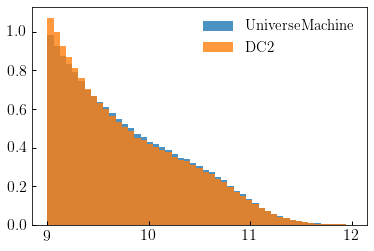

In [ ]:
fig, ax = plt.subplots(1, 1)

logsm_bins=np.linspace(9, 12, 50)

__=ax.hist(np.log10(umachine_z0['obs_sm']), bins=logsm_bins, normed=True, 
          alpha=0.8, label=r'${\rm UniverseMachine}$')

__=ax.hist(np.log10(protoDC2_z0['rescaled_mstar']), bins=logsm_bins, normed=True, 
          alpha=0.8, label=r'${\rm DC2}$')

legend = ax.legend()

### Satellite fraction

The disagreement is due to the baseline HOD being discrepant

In [ ]:
from scipy.stats import binned_statistic

logsm_bins=np.linspace(9, 12, 50)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

fsat_um, __, __ = binned_statistic(
    np.log10(umachine_z0['obs_sm']), umachine_z0['upid']!=-1,
    statistic='mean', bins=logsm_bins)
fsat_dc2, __, __ = binned_statistic(
    np.log10(protoDC2_z0['rescaled_mstar']), protoDC2_z0['isCentral']==0, 
    statistic='mean', bins=logsm_bins)
fsat_pdc2, __, __ = binned_statistic(
    np.log10(protoDC2_z0['totalMassStellar']), protoDC2_z0['isCentral']==0, 
    statistic='mean', bins=logsm_bins)

fig, ax = plt.subplots(1, 1)

__=ax.plot(logsm_mids, fsat_um, label=r'${\rm UniverseMachine}$')
__=ax.plot(logsm_mids, fsat_dc2, label=r'${\rm DC2}$')
__=ax.plot(logsm_mids, fsat_pdc2, '--', label=r'${\rm proto}$-${\rm DC2}$')

legend = ax.legend()